<a href="https://colab.research.google.com/github/marcosw1998/Data-Science/blob/main-mwac/Analysis_Notebook/covid_spends_brazil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dos custos do governo de Pernambuco - BR em relação à Covid-19
* Projeto corresponde a entrega parcial para avaliação na cadeira eletiva IF697 - Intro. a Ciência dos Dados
* Autores: Igor Silva e Marcos Cavalcanti
* Conjunto de dados públicos retirados das seguintes fontes:
  * [Portal da Transparência TCU](http://www.portaltransparencia.gov.br/coronavirus)
  * [Prefeitura do Recife](http://dados.recife.pe.gov.br/dataset?tags=sa%C3%BAde)
  * [Brasil.io](https://brasil.io/dataset/covid19/caso_full/)



## Por quê o tema?

* Interesse em entender e expor de forma clara os gastos públicos
* Analisar distribuição de gastos
* Covis-19 é um tema importante e merece muita atenção, pois tem feito muitas vítimas e mudado a forma como a sociedade pensa e se organiza
* Entender a distribuição de gastos é uma boa forma de tentar corrigir erros e minimizar danos futuros na economia e na sociedade

## Carregando as bibliotecas

  * Utilizaremos a biblioteca ***`Pandas`*** para trabalhar sobre os dados  e a biblioteca ***`Numpy`*** para geração de gráficos.
  



In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 68kB/s 
     |████████████████████████████████| 204kB 17.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=6e9627ff16d2902413fd9fc441e8a465450dfb70777468aeacaa13cb8c906a56
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
import pyspark
from pyspark import SparkContext
sc = SparkContext("local", "first app")

## Carregando os dados

  * Utilizaremos a lib ***`requests`*** para carregar os dados em formato csv e em seguida convertê-los em JSON
  * Referência: https://www.nylas.com/blog/use-python-requests-module-rest-apis/ 
  * Instalação
     ```
      !pip install requests
      ```



In [ ]:
!pip install requests

#### Persistência de dados no Google Drive
Caso necessário, executar célula abaixo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

### Portal da transparência

* O portal da transparência permite que sejam baixados apenas 1000 registros por vez, portanto decidimos por baixar 2 datasets diferentes e depois fazermos a junção. Os dados são referentes a algumas cidades de Pernambuco 
(ARCOVERDE, BUÍQUE, CARUARU, GARANHUNS, JABOATÃO DOS GUARARAPES, OLINDA, PAULISTA, PETROLINA, RECIFE, SERRA TALHADA)

In [24]:
invest_covidPe = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/covid-pe.csv",encoding = "utf-8")
invest_covidPe2 = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/transferencias_coronavirus.csv",encoding = "utf-8")

In [25]:
#Validando os dados do dataset invest_covidPe
print('Dataset 1',invest_covidPe.shape)
invest_covidPe.sort_values("Município").head()

Dataset 1 (561, 12)


,Mês/Ano,Tipo,Tipo de Favorecido,UF,Nome do Favorecido,CPF/CNPJ,Município,Função,Programa Orçamentário,Ação Orçamentária,Linguagem Cidadã,Valor Transferido
182,nov/20,Legais. Voluntárias e Específicas,Fundo Público,PE,FUNDO MUNICIPAL DE SAUDE,11.371.082/0001-05,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,Sem informação,486.515.00
178,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,ASSOCICAO DE PAIS E MESTRES,11.252.224/0001-07,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,7.897.02
179,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CONSELHO ESCOLAR MARIA DO SOCORRO DE FREITAS,02.021.769/0001-11,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,2.837.48
87,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CONSELHO ESCOLAR DOM BERNARDINO MARCHIO,34.179.420/0001-07,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,8.427.56
181,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,UNIDADE EXECUTORA MAJOR DR.SINVAL,11.441.171/0001-72,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,2.274.59


In [26]:
#Validando os dados do dataset invest_covidPe2
print('Dataset 2',invest_covidPe2.shape)
invest_covidPe2.sort_values("Município").head()

Dataset 2 (140, 10)


,Mês/Ano,Tipo,Ação Orçamentária,Programa Orçamentário,Função,Tipo de Favorecido,UF,Município,Valor Transferido,Unnamed: 9
98,12/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 134.639.00,NaN
41,05/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 470.809.62,NaN
42,11/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 355.594.00,NaN
32,04/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 761.895.71,NaN
56,08/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 218.971.54,NaN


*Podemos perceber que o Dataset **invest_covidPe** possui mais colunas que o Dataset **invest_covidPe2**.  Também notamos que o Dataset invest_covidPe2 possui uma coluna com dados Nan, vamos tratar disso no pré processamento antes de fazer a concatenação dos dois Datasets*

### Dados abertos - Prefeitura do Recife

In [ ]:
import requests

#dados_pref_rmr = requests.get("http://dados.recife.pe.gov.br/dataset/6c77a814-7161-4eb5-9662-234642dc8cc1/resource/63376b8c-0271-42eb-a88b-cc75c1c3f3fc/download/metadados-hospitais.json").json()

### Dados públicos em open APIs

In [ ]:
#dados_api = requests.get("https://brasil.io/dataset/covid19/caso_full/").json()

### Dados de casos de Covid-19 por todo o estado de Pernambuco. 
Os valores estão atualizados até o dia 17/03/2021 e foram buscados através do Brasil.io

In [27]:
covidPeCases = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/covid19-1703-casos.csv",encoding = "utf-8")
print(covidPeCases.shape)
covidPeCases.sort_values("city").head()

(187, 16)


,epidemiological_week,date,order_for_place,state,city,city_ibge_code,place_type,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population,is_last,is_repeated
1,202111,2021-03-15,341,PE,Abreu e Lima,2600054.0,city,1700,1694.13828,8,159,1,0.0935,100346.0,True,False
2,202111,2021-03-15,321,PE,Afogados da Ingazeira,2600104.0,city,2478,6624.95990,1,35,0,0.0141,37404.0,True,False
3,202111,2021-03-15,321,PE,Afrânio,2600203.0,city,578,2917.71832,0,9,0,0.0156,19810.0,True,False
4,202111,2021-03-15,326,PE,Agrestina,2600302.0,city,865,3451.02733,2,36,0,0.0416,25065.0,True,False
7,202111,2021-03-15,331,PE,Alagoinha,2600609.0,city,443,3009.91983,0,13,0,0.0293,14718.0,True,False


## Pré Processamento
  * Junção de datasets em Dataframe Pandas
  * Tratamento de dados ```NaN```/```null``` ou corrompidos
  * Conversão de tipos
  * Transformação e identificação de dados categóricos
  * Remoção de ***Outliers***

### Dados sobre investimentos do governo

In [28]:
# Verificando se existem registros duplicados
print("Número de registros duplicados")
print("Dataset 1",len(invest_covidPe[invest_covidPe.duplicated()]))
print("Dataset 2",len(invest_covidPe2[invest_covidPe2.duplicated()]))


Número de registros duplicados
Dataset 1 0
Dataset 2 0


In [29]:
#Checando se temos valores Nan
print('Dataset 1',invest_covidPe.isnull().sum())
print('Dataset 1',invest_covidPe2.isnull().sum())

Dataset 1 Mês/Ano                  0
Tipo                     0
Tipo de Favorecido       0
UF                       0
Nome do Favorecido       0
CPF/CNPJ                 0
Município                0
Função                   0
Programa Orçamentário    0
Ação Orçamentária        0
Linguagem Cidadã         0
Valor Transferido        0
dtype: int64
Dataset 1 Mês/Ano                    0
Tipo                       0
Ação Orçamentária          0
Programa Orçamentário      0
Função                     0
Tipo de Favorecido         0
UF                         0
Município                  0
Valor Transferido          0
Unnamed: 9               140
dtype: int64


In [30]:
#Dropando colunas que não fazem parte do dataset invest_covidPe2 e que não influem sobre os nossos estudos (Nome do favorecido, CPF/CNPJ, Linguagem Cidadã)
invest_covidPe = invest_covidPe.dropna(axis=1, how='all')
cols = [4,5,10]
invest_covidPe.drop(invest_covidPe.columns[cols],axis=1,inplace=True)
invest_covidPe.sort_values("Município").head()

,Mês/Ano,Tipo,Tipo de Favorecido,UF,Município,Função,Programa Orçamentário,Ação Orçamentária,Valor Transferido
182,nov/20,Legais. Voluntárias e Específicas,Fundo Público,PE,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,486.515.00
178,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,7.897.02
179,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,2.837.48
87,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,8.427.56
181,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,2.274.59


In [31]:
#Dropando coluna que tem todos os valores Nan
invest_covidPe2.dropna(axis=1, how='all',inplace=True)
invest_covidPe2.sort_values("Município").head()

,Mês/Ano,Tipo,Ação Orçamentária,Programa Orçamentário,Função,Tipo de Favorecido,UF,Município,Valor Transferido
98,12/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 134.639.00
41,05/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 470.809.62
42,11/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 355.594.00
32,04/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 761.895.71
56,08/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 218.971.54


In [32]:
#Confirmando que as colunas foram removidas e agora os 2 datasets possuem a mesma quantidade de colunas
print('Dataset 1',invest_covidPe.shape)
print('Dataset 2',invest_covidPe2.shape)

Dataset 1 (561, 9)
Dataset 2 (140, 9)


In [33]:
#Fazendo a concatenação dos Dataframes, o resultado final de linhas é igual ao somatório de linhas entre ambos os Datasets
invest_covidPe = invest_covidPe.append(invest_covidPe2, ignore_index=True)

### A partir de agora trabalharemos apenas sobre o invest_covidPe, o invest_covidPe2 está descartado.

In [34]:
# Verificando se existem registros duplicados
print("Número de registros duplicados")
print("Dataset 1",len(invest_covidPe[invest_covidPe.duplicated()]))

Número de registros duplicados
Dataset 1 25


In [35]:
#No entanto os valores levantados como duplicados são falsos positivos
invest_covidPe[invest_covidPe.duplicated()].sort_values("Município").tail(5)

,Mês/Ano,Tipo,Tipo de Favorecido,UF,Município,Função,Programa Orçamentário,Ação Orçamentária,Valor Transferido
312,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,RECIFE,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,1.782.87
248,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,RECIFE,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,2.002.85
217,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,RECIFE,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,1.549.95
135,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,RECIFE,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,2.242.24
120,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,RECIFE,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,3.031.58


### Conversão de tipos das colunas 

  * Valor Transferido (rename -> gastos): ```string``` -> ```float```

  * Mês/Ano (rename -> data_hora): ```string``` -> ```pandas.Datetime```

  * Dados categóricos: ```object``` -> ```category```

In [36]:
invest_covidPe.dtypes

Mês/Ano                  object
Tipo                     object
Tipo de Favorecido       object
UF                       object
Município                object
Função                   object
Programa Orçamentário    object
Ação Orçamentária        object
Valor Transferido        object
dtype: object

#### Valor Transferido
```object``` -> ```float64```

In [37]:
# Tratamento e conversão do CSV-String para float
invest_covidPe['valores_transferidos'] = invest_covidPe['Valor Transferido'].apply(lambda words: words.replace('R$ ', ''))
valores_transferidos = invest_covidPe['valores_transferidos'].map(lambda words: float(words[:-3].replace('.','') + words[-3:]))
valores_transferidos = valores_transferidos.astype('float64')
#valores_transferidos = valores_transferidos.astype(float)

In [38]:
invest_covidPe.head(3)

,Mês/Ano,Tipo,Tipo de Favorecido,UF,Município,Função,Programa Orçamentário,Ação Orçamentária,Valor Transferido,valores_transferidos
0,mar/20,Legais. Voluntárias e Específicas,Fundo Público,PE,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,60.000.00,60.000.00
1,abr/20,Legais. Voluntárias e Específicas,Fundo Público,PE,GARANHUNS,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,1.174.944.27,1.174.944.27
2,abr/20,Legais. Voluntárias e Específicas,Fundo Público,PE,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,4.130.446.89,4.130.446.89


In [39]:
# Atualiza o dataset principal
invest_covidPe['Valor Transferido'].update(valores_transferidos)
invest_covidPe.drop('valores_transferidos',axis=1,inplace=True)
invest_covidPe = invest_covidPe.infer_objects()

In [40]:
# Modifica nome das colunas com espaços e caracteres especiais
invest_covidPe = invest_covidPe.rename(columns={"Mês/Ano": "data_hora",\
                                                "Tipo de Favorecido": "favorecido",\
                                                "Município": "municipio",\
                                                "Função": "funcao",\
                                                "Programa Orçamentário": "prog_ocamentario", \
                                                "Ação Orçamentária": "acao_orcamentaria", \
                                                "Valor Transferido": "gastos"})
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data_hora          701 non-null    object 
 1   Tipo               701 non-null    object 
 2   favorecido         701 non-null    object 
 3   UF                 701 non-null    object 
 4   municipio          701 non-null    object 
 5   funcao             701 non-null    object 
 6   prog_ocamentario   701 non-null    object 
 7   acao_orcamentaria  701 non-null    object 
 8   gastos             701 non-null    float64
dtypes: float64(1), object(8)
memory usage: 49.4+ KB


#### Data (timestamp)
```object``` -> ```pandas.Datetime```

Obs.: Apenas necessário para o caso de análise de séries temporais.

In [41]:
# Transformando os dados da coluna data_hora em pandas.Datetime
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('string')
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data_hora          701 non-null    string 
 1   Tipo               701 non-null    object 
 2   favorecido         701 non-null    object 
 3   UF                 701 non-null    object 
 4   municipio          701 non-null    object 
 5   funcao             701 non-null    object 
 6   prog_ocamentario   701 non-null    object 
 7   acao_orcamentaria  701 non-null    object 
 8   gastos             701 non-null    float64
dtypes: float64(1), object(7), string(1)
memory usage: 49.4+ KB


In [42]:
meses = {'mar/20' : '2020-03-10', \
         'abr/20' : '2020-04-10', \
         'mai/20' : '2020-05-10', \
         'jun/20' : '2020-06-10', \
         'jul/20' : '2020-07-10', \
         'ago/20' : '2020-08-10', \
         'set/20' : '2020-09-10', \
         'out/20' : '2020-10-10', \
         'nov/20' : '2020-11-10', \
         'dez/20' : '2020-12-10', \
         '03/2020' : '2020-03-10', \
         '04/2020' : '2020-04-10', \
         '05/2020' : '2020-05-10', \
         '06/2020' : '2020-06-10', \
         '07/2020' : '2020-07-10', \
         '08/2020' : '2020-08-10', \
         '09/2020' : '2020-09-10', \
         '10/2020' : '2020-10-10', \
         '11/2020' : '2020-11-10', \
         '12/2020' : '2020-12-10'
         }

invest_covidPe['data_hora'] = invest_covidPe['data_hora'].apply(lambda dates: dates.replace(dates, meses[dates]))

invest_covidPe['data_hora'].unique()

array(['2020-03-10', '2020-04-10', '2020-05-10', '2020-06-10',
       '2020-07-10', '2020-08-10', '2020-09-10', '2020-10-10',
       '2020-11-10', '2020-12-10'], dtype=object)

In [43]:
# convert the 'Date' column to datetime format
invest_covidPe['data_hora'] = pd.to_datetime(invest_covidPe['data_hora'])

# Check the format of 'Date' column
invest_covidPe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data_hora          701 non-null    datetime64[ns]
 1   Tipo               701 non-null    object        
 2   favorecido         701 non-null    object        
 3   UF                 701 non-null    object        
 4   municipio          701 non-null    object        
 5   funcao             701 non-null    object        
 6   prog_ocamentario   701 non-null    object        
 7   acao_orcamentaria  701 non-null    object        
 8   gastos             701 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 49.4+ KB


### Casos de Covid-19 por todo o estado de Pernambuco.

In [44]:
#Alterando o nome e filtrando as colunas que decidimos analisar
covidPeCases= covidPeCases.filter(items=['city', 'last_available_confirmed','last_available_deaths','last_available_death_rate','estimated_population'])

covidPeCases= covidPeCases.rename(columns={"city": "municipio", "last_available_confirmed": "casos_confirmados", 
                   "last_available_deaths": "mortes_confirmadas", "last_available_death_rate": "taxa_mortalidade",
                   "estimated_population": "pop_estimada"})

In [45]:
#Guardando uma cópia dos dados de todas as cidades
oldCovidPeCases = covidPeCases

#Filtrando as cidades que selecionamos os gastos no portal da transparência
cities = ['Arcoverde', 'Buíque', 'Caruaru', 'Garanhuns', 'Jaboatão dos Guararapes', 'Olinda', 'Paulista', 'Petrolina', 'Recife', 'Serra Talhada']
covidPeCases = covidPeCases[covidPeCases.municipio.isin(cities)]
covidPeCases

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada
14,Arcoverde,4281,87,0.0203,74822.0
30,Buíque,1436,23,0.0160,58919.0
45,Caruaru,17187,454,0.0264,365278.0
67,Garanhuns,7250,134,0.0185,140577.0
89,Jaboatão dos Guararapes,19966,1095,0.0548,706867.0
113,Olinda,14581,635,0.0435,393115.0
124,Paulista,7154,528,0.0738,334376.0
128,Petrolina,18239,209,0.0115,354317.0
134,Recife,78117,3168,0.0406,1653461.0
160,Serra Talhada,7341,105,0.0143,86915.0


In [48]:
#Criando um campo que nos permita relacionar a quantidade de casos confirmados pela população estimada
covidPeCases['confirmados_por_populacao'] = covidPeCases['casos_confirmados']/covidPeCases['pop_estimada']
covidPeCases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,confirmados_por_populacao
14,Arcoverde,4281,87,0.0203,74822.0,0.057216
30,Buíque,1436,23,0.0160,58919.0,0.024372
45,Caruaru,17187,454,0.0264,365278.0,0.047052
67,Garanhuns,7250,134,0.0185,140577.0,0.051573
89,Jaboatão dos Guararapes,19966,1095,0.0548,706867.0,0.028246
113,Olinda,14581,635,0.0435,393115.0,0.037091
124,Paulista,7154,528,0.0738,334376.0,0.021395
128,Petrolina,18239,209,0.0115,354317.0,0.051477
134,Recife,78117,3168,0.0406,1653461.0,0.047245
160,Serra Talhada,7341,105,0.0143,86915.0,0.084462


In [49]:
covidPeCases.dtypes

municipio                     object
casos_confirmados              int64
mortes_confirmadas             int64
taxa_mortalidade             float64
pop_estimada                 float64
confirmados_por_populacao    float64
dtype: object

Ajustando tipo e transformando valores para porcentagem a fim de facilitar a percepção das taxas

In [50]:
covidPeCases['pop_estimada'] = covidPeCases['pop_estimada'].apply(np.int64)
covidPeCases['taxa_mortalidade'] = covidPeCases['taxa_mortalidade'] * 100
covidPeCases['confirmados_por_populacao'] = (covidPeCases['confirmados_por_populacao'] * 100).round(2)
covidPeCases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,confirmados_por_populacao
14,Arcoverde,4281,87,2.03,74822,5.72
30,Buíque,1436,23,1.60,58919,2.44
45,Caruaru,17187,454,2.64,365278,4.71
67,Garanhuns,7250,134,1.85,140577,5.16
89,Jaboatão dos Guararapes,19966,1095,5.48,706867,2.82
113,Olinda,14581,635,4.35,393115,3.71
124,Paulista,7154,528,7.38,334376,2.14
128,Petrolina,18239,209,1.15,354317,5.15
134,Recife,78117,3168,4.06,1653461,4.72
160,Serra Talhada,7341,105,1.43,86915,8.45


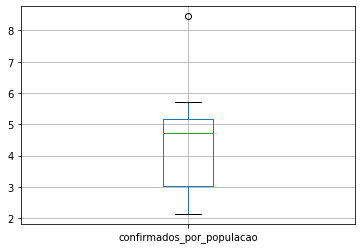

In [51]:
covidPeCases.boxplot(column=['confirmados_por_populacao'])

In [52]:
investimentoporcidade = invest_covidPe.groupby(by=['municipio']).sum()
investimentoporcidade

,gastos
municipio,
ARCOVERDE,7.993327e+06
BUÍQUE,3.872970e+06
CARUARU,5.164707e+07
GARANHUNS,3.445661e+07
JABOATÃO DOS GUARARAPES,9.509845e+07
OLINDA,4.233129e+07
PAULISTA,1.294073e+07
PETROLINA,1.216093e+08
RECIFE,3.015280e+08


### Adicionando gastos totais e gastos por habitante ao DataSet de casos

In [53]:
covidPeCases['gastos'] = investimentoporcidade['gastos'].values
covidPeCases['gastos_por_habitante'] = (covidPeCases['gastos'] / covidPeCases['pop_estimada']) .round(2)
covidPeCases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,confirmados_por_populacao,gastos,gastos_por_habitante
14,Arcoverde,4281,87,2.03,74822,5.72,7.993327e+06,106.83
30,Buíque,1436,23,1.60,58919,2.44,3.872970e+06,65.73
45,Caruaru,17187,454,2.64,365278,4.71,5.164707e+07,141.39
67,Garanhuns,7250,134,1.85,140577,5.16,3.445661e+07,245.11
89,Jaboatão dos Guararapes,19966,1095,5.48,706867,2.82,9.509845e+07,134.54
113,Olinda,14581,635,4.35,393115,3.71,4.233129e+07,107.68
124,Paulista,7154,528,7.38,334376,2.14,1.294073e+07,38.70
128,Petrolina,18239,209,1.15,354317,5.15,1.216093e+08,343.22
134,Recife,78117,3168,4.06,1653461,4.72,3.015280e+08,182.36
160,Serra Talhada,7341,105,1.43,86915,8.45,1.535898e+07,176.71


##Discretização dos gastos por habitante - 
Nível de gastos : 1 - Muito baixo, 2 - Baixo 3 - Médio, 4 - Alto 5 - Muito alto

In [54]:
print('intervalos', pd.cut(covidPeCases['gastos_por_habitante'].values,5).categories)
covidPeCases['nivel_de_gastos'] = pd.cut(covidPeCases['gastos_por_habitante'].values,5).codes + 1
covidPeCases

intervalos IntervalIndex([(38.395, 99.604], (99.604, 160.508], (160.508, 221.412], (221.412, 282.316], (282.316, 343.22]],
              closed='right',
              dtype='interval[float64]')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,confirmados_por_populacao,gastos,gastos_por_habitante,nivel_de_gastos
14,Arcoverde,4281,87,2.03,74822,5.72,7.993327e+06,106.83,2
30,Buíque,1436,23,1.60,58919,2.44,3.872970e+06,65.73,1
45,Caruaru,17187,454,2.64,365278,4.71,5.164707e+07,141.39,2
67,Garanhuns,7250,134,1.85,140577,5.16,3.445661e+07,245.11,4
89,Jaboatão dos Guararapes,19966,1095,5.48,706867,2.82,9.509845e+07,134.54,2
113,Olinda,14581,635,4.35,393115,3.71,4.233129e+07,107.68,2
124,Paulista,7154,528,7.38,334376,2.14,1.294073e+07,38.70,1
128,Petrolina,18239,209,1.15,354317,5.15,1.216093e+08,343.22,5
134,Recife,78117,3168,4.06,1653461,4.72,3.015280e+08,182.36,3
160,Serra Talhada,7341,105,1.43,86915,8.45,1.535898e+07,176.71,3


In [55]:
covidPeCases.corr(method='spearman')

,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,confirmados_por_populacao,gastos,gastos_por_habitante,nivel_de_gastos
casos_confirmados,1.000000,0.793939,0.187879,0.903030,0.054545,0.975758,0.612121,0.503503
mortes_confirmadas,0.793939,1.000000,0.709091,0.963636,-0.357576,0.757576,0.151515,0.069232
taxa_mortalidade,0.187879,0.709091,1.000000,0.551515,-0.624242,0.115152,-0.515152,-0.547560
pop_estimada,0.903030,0.963636,0.551515,1.000000,-0.236364,0.878788,0.321212,0.213989
confirmados_por_populacao,0.054545,-0.357576,-0.624242,-0.236364,1.000000,0.078788,0.612121,0.736374
gastos,0.975758,0.757576,0.115152,0.878788,0.078788,1.000000,0.696970,0.591616
gastos_por_habitante,0.612121,0.151515,-0.515152,0.321212,0.612121,0.696970,1.000000,0.962950
nivel_de_gastos,0.503503,0.069232,-0.547560,0.213989,0.736374,0.591616,0.962950,1.000000


### Dados categóricos

In [56]:
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('category')
invest_covidPe['Tipo'] = invest_covidPe['Tipo'].astype('category')
invest_covidPe['favorecido'] = invest_covidPe['favorecido'].astype('category')
invest_covidPe['UF'] = invest_covidPe['UF'].astype('category')
invest_covidPe['municipio'] = invest_covidPe['municipio'].astype('category')
invest_covidPe['funcao'] = invest_covidPe['funcao'].astype('category')
invest_covidPe['prog_ocamentario'] = invest_covidPe['prog_ocamentario'].astype('category')
invest_covidPe['acao_orcamentaria'] = invest_covidPe['acao_orcamentaria'].astype('category')
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   data_hora          701 non-null    category
 1   Tipo               701 non-null    category
 2   favorecido         701 non-null    category
 3   UF                 701 non-null    category
 4   municipio          701 non-null    category
 5   funcao             701 non-null    category
 6   prog_ocamentario   701 non-null    category
 7   acao_orcamentaria  701 non-null    category
 8   gastos             701 non-null    float64 
dtypes: category(8), float64(1)
memory usage: 12.9 KB


### Remoção de outliers
  * Isolation Forest
  * Local Outlier Factor

In [ ]:
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].cat.codes
invest_covidPe['Tipo'] = invest_covidPe['Tipo'].cat.codes
invest_covidPe['favorecido'] = invest_covidPe['favorecido'].cat.codes
invest_covidPe['UF'] = invest_covidPe['UF'].cat.codes
invest_covidPe['municipio'] = invest_covidPe['municipio'].cat.codes
invest_covidPe['funcao'] = invest_covidPe['funcao'].cat.codes
invest_covidPe['prog_ocamentario'] = invest_covidPe['prog_ocamentario'].cat.codes
invest_covidPe['acao_orcamentaria'] = invest_covidPe['acao_orcamentaria'].cat.codes

Para avaliação do melhor resultado para remoção de outliers, serão utilizados 
cópias dos dataframes gerados

In [ ]:
invest_covidPe_forest = invest_covidPe
invest_covidPe_lof = invest_covidPe

In [ ]:
print("Quantidade de linhas: " + str(len(invest_covidPe)))

Quantidade de linhas: 701


#### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(invest_covidPe_forest)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=100, n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F9A7EB44160, verbose=0,
                warm_start=False)

In [ ]:
scores = clf.predict(invest_covidPe_forest)

In [ ]:
scores

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1,  1

In [ ]:
invest_covidPe_forest['outlier'] = scores
print(invest_covidPe_forest.head())

   data_hora  Tipo  favorecido  ...  acao_orcamentaria      gastos  outlier
0          0     0           2  ...                  3    60000.00       -1
1          1     0           2  ...                  3  1174944.27       -1
2          1     0           2  ...                  3  4130446.89       -1
3          1     0           2  ...                  3  3830136.03       -1
4          1     0           2  ...                  3  3662675.00       -1

[5 rows x 10 columns]


In [ ]:
invest_covidPe_forest[invest_covidPe_forest['outlier'] == -1]

,data_hora,Tipo,favorecido,UF,municipio,funcao,prog_ocamentario,acao_orcamentaria,gastos,outlier
0,0,0,2,0,8,7,0,3,60000.00,-1
1,1,0,2,0,3,7,0,3,1174944.27,-1
2,1,0,2,0,7,7,0,3,4130446.89,-1
3,1,0,2,0,5,7,0,3,3830136.03,-1
4,1,0,2,0,2,7,0,3,3662675.00,-1
...,...,...,...,...,...,...,...,...,...,...
696,1,0,2,0,4,1,0,1,7327021.87,-1
697,7,0,2,0,8,1,0,1,3500000.00,-1
698,4,0,2,0,7,1,0,1,8676053.00,-1
699,4,0,2,0,1,1,0,1,1850000.00,-1


In [ ]:
invest_covidPe_forest = invest_covidPe_forest[invest_covidPe_forest['outlier'] != -1]
len(invest_covidPe_forest)

475

#### Local Outlier Factor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)

In [ ]:
scores = clf.fit_predict(invest_covidPe_lof)

In [ ]:
# Valor de LOF
-1*clf.negative_outlier_factor_

array([ 5.06972406,  1.15786907,  1.01278478,  1.00743069,  0.97511367,
        1.38735342,  1.14246381,  0.9815729 ,  0.9388996 ,  1.06181494,
        1.03345647,  1.00099309,  1.46929686,  0.96742529,  1.19792081,
        1.05815846,  1.32094043,  1.11359083,  0.88391166,  1.28701849,
        1.0212535 ,  1.05815846,  1.0811027 ,  1.03028305,  0.96950344,
        1.09989847,  1.71633666,  1.09000524,  1.17392687,  1.32513546,
        1.24460724,  1.24460724,  0.98706486,  0.95898566,  0.9073941 ,
        1.17776213,  1.30074647,  0.94080509,  1.1715444 ,  1.04785782,
        0.98969908,  1.22973992,  0.93931047,  1.10569106,  1.11086792,
        1.0155732 ,  0.95207123,  1.0404531 ,  1.40262619,  1.03760092,
        0.98506441,  1.31220308,  0.94483734,  1.00836771,  1.03237359,
        1.37091875,  1.17742638,  0.99612669,  1.02220098,  0.93716132,
        0.99639615,  1.03726531,  1.04823382,  1.4031783 ,  1.0998123 ,
        1.15410589,  1.13631687,  1.024645  ,  1.08351131,  0.97

In [ ]:
scores

array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [ ]:
invest_covidPe_lof['outlier'] = scores
print(invest_covidPe_lof.head())

   data_hora  Tipo  favorecido  ...  acao_orcamentaria      gastos  outlier
0          0     0           2  ...                  3    60000.00       -1
1          1     0           2  ...                  3  1174944.27        1
2          1     0           2  ...                  3  4130446.89        1
3          1     0           2  ...                  3  3830136.03        1
4          1     0           2  ...                  3  3662675.00        1

[5 rows x 10 columns]


In [ ]:
invest_covidPe_lof[invest_covidPe_lof['outlier'] == -1]

,data_hora,Tipo,favorecido,UF,municipio,funcao,prog_ocamentario,acao_orcamentaria,gastos,outlier
0,0,0,2,0,8,7,0,3,60000.00,-1
26,3,0,2,0,8,4,2,3,2264395.80,-1
96,8,0,1,0,8,6,1,2,-534.86,-1
149,8,0,1,0,8,6,1,2,-1084.16,-1
212,8,0,1,0,7,6,1,2,12037.82,-1
241,8,0,1,0,8,6,1,2,-1248.01,-1
243,8,0,1,0,8,6,1,2,-2529.72,-1
259,8,0,1,0,2,6,1,2,1342.91,-1
562,8,0,1,0,8,2,1,0,-1619.02,-1
589,8,0,1,0,8,2,1,0,-3777.73,-1


In [ ]:
invest_covidPe_lof = invest_covidPe_lof[invest_covidPe_lof['outlier'] != -1]
len(invest_covidPe_lof)

688

### Conversão do DF para trabalhar com distribuição temporal
Conversão necessária para o desenvolvimento dos métodos de séries temporais

In [ ]:
# convert the 'Date' column to datetime format
invest_covidPe['data_hora'] = pd.to_datetime(invest_covidPe['data_hora'])

# Check the format of 'Date' column
invest_covidPe.info()

In [ ]:
invest_covidPe.set_index('data_hora')

## Análise dos casos

  * ***Insights***:

    * Distribuição de gastos do Estado de Pernambuco entre:
      * Regiões (RMR, Zona da mata, Agreste, Sertão)
      * Capital e outras cidades

    * Cidades com maiores quantidades de Hospitais Públicos
      * Distribuição de gastos em relação à quantidade de Hospitais

## Visualização dos dados

### A finalidade desse gráfico é nos ajudar na validação da hipóteseve de que nas cidades onde houve menos investimento, a taxa de mortalidade consequentemente foi maior

[Text(0, 0.5, 'Taxa de Mortalidade'),
 Text(0.5, 0, 'Nível de Gastos'),
 Text(0.5, 1.0, 'Relação Nível de Gastos x Taxa de Mortalidade')]

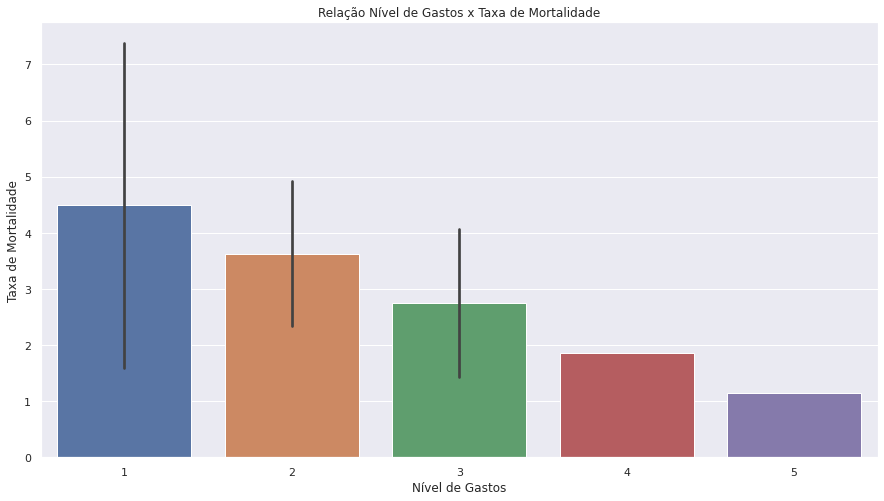

In [492]:
sns.set()
plt.figure(figsize=(15,8))
sns.barplot(x='nivel_de_gastos', y='taxa_mortalidade', data=covidPeCases).set(title='Relação Nível de Gastos x Taxa de Mortalidade', xlabel='Nível de Gastos', ylabel='Taxa de Mortalidade')

### Distribuição
Estatística descritiva de cada caso
* `df.describe()`

##### Habitante

##### Município

##### Zona Geográfica
  * RMR
  * Zona da Mata
  * Agreste

### Média móvel

### Análises dos gastos
  * por Data (mensal)
  * por Habitante (Total)

In [488]:
#Investimentos por Mês

dates = pd.date_range('10-Mar 2020','10-jan 2021',freq='M')
df = pd.DataFrame({'dates' : dates})
df['month_name'] = df['dates'].dt.strftime('%b')
df['gastos'] = invest_covidPe.groupby(by=['data_hora']).sum().values
# normalizando entre -1 e 1 para nos permitir verificar os meses em que tivemos o investimento menores dada a escala
df['gastos_norm'] = ((df['gastos'] - df['gastos'].min()) / (df['gastos'].max()-df['gastos'].min())*2)-1
#Aplicando log10 para visualizarmos em proporções parecidas
df['gastos_log10'] = df['gastos'].apply(np.log10)

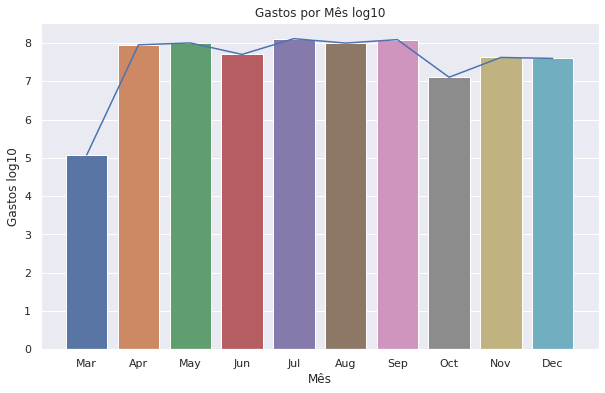

In [491]:
#Visão com log10
plt.figure(figsize=(10,6))
sns.barplot(x='month_name', y='gastos_log10', data=df).set(title='Gastos por Mês log10', xlabel='Mês', ylabel='Gastos log10')
sns.lineplot(x='month_name', y='gastos_log10', data=df)

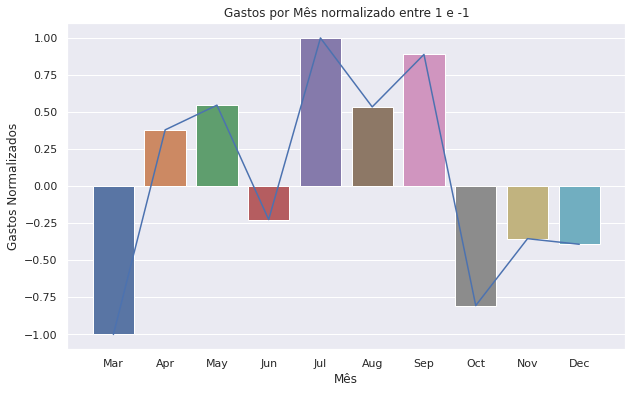

In [490]:
 #Visão com valores normalizados entre -1 e 1
plt.figure(figsize=(10,6))
sns.barplot(x='month_name', y='gastos_norm', data=df).set(title='Gastos por Mês normalizado entre -1 e 1', xlabel='Mês', ylabel='Gastos Normalizados')
sns.lineplot(x='month_name', y='gastos_norm', data=df)

[Text(0, 0.5, 'Nível de Investimentos'),
 Text(0.5, 0, 'Município'),
 Text(0.5, 1.0, 'Nível de Investimentos por Município')]

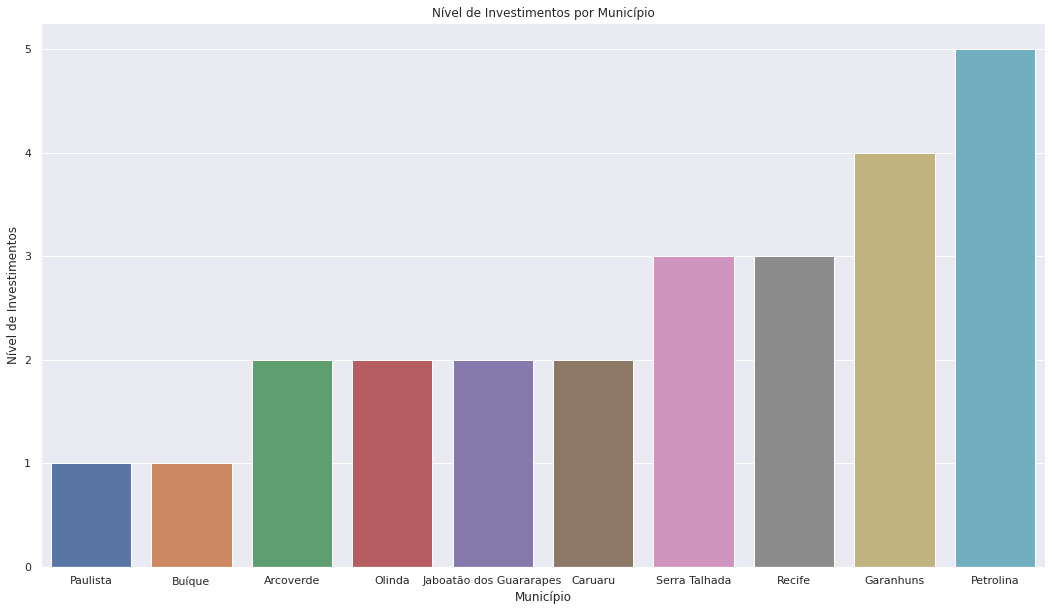

In [445]:
sns.set()
plt.figure(figsize=(18,10))

aux = covidPeCases.filter(items=['municipio', 'gastos_por_habitante','taxa_mortalidade','nivel_de_gastos']).sort_values(by=['gastos_por_habitante'])
sns.barplot(x='municipio', y='nivel_de_gastos', data=aux).set(title='Nível de Investimentos por Município', xlabel='Município', ylabel='Nível de Investimentos')

[Text(0, 0.5, 'Taxa de Mortalidade'),
 Text(0.5, 0, 'Município'),
 Text(0.5, 1.0, 'Taxa de mortalidade por Município')]

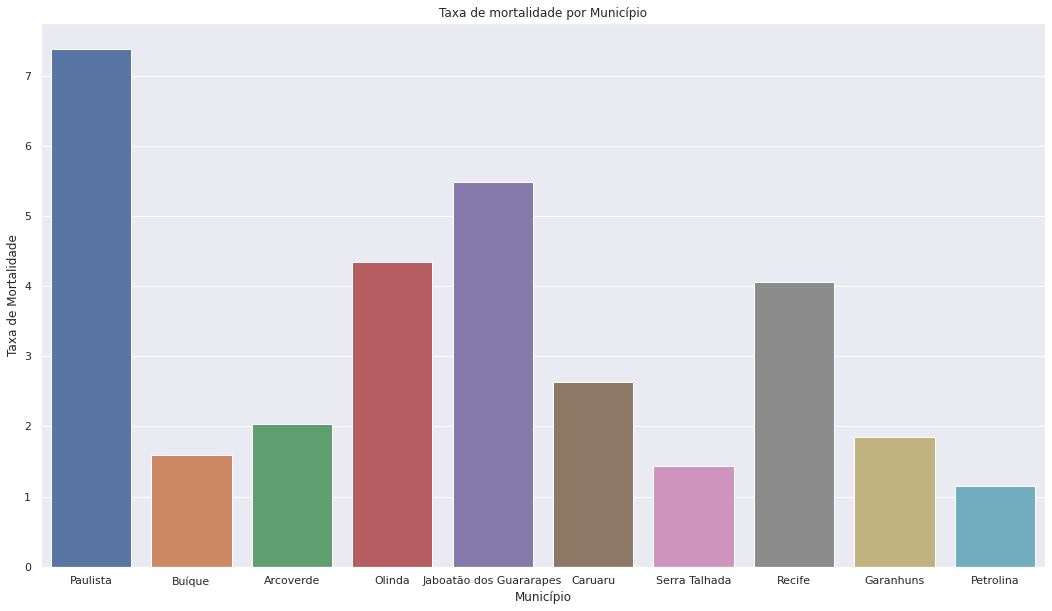

In [444]:
plt.figure(figsize=(18,10))
sns.barplot(x='municipio', y='taxa_mortalidade', data=aux).set(title='Taxa de mortalidade por Município', xlabel='Município', ylabel='Taxa de Mortalidade')

## Teste de hipótese
### Hipótese : As cidades que tiveram um nível de gastos de médio para muito alto (3,5) obtiveram níveis menores de mortalidade do que as cidades que investiram menos (1,2). Utilizaremos o valor crítico de 3%

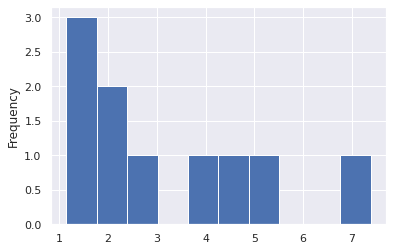

In [405]:
#Não segue uma normal
aux['taxa_mortalidade'].plot.hist()

In [ ]:
#Como nossos dados tratam de grupos não pareados e que não seguem uma distribuição normal, vamos utilizar o teste de mannwhitneyu
stats.mannwhitneyu(aux[aux['nivel_de_gastos'] <= 2]['taxa_mortalidade'],aux[aux['nivel_de_gastos'] >=3]['taxa_mortalidade'])

MannwhitneyuResult(statistic=4.0, pvalue=0.05490970440761861)

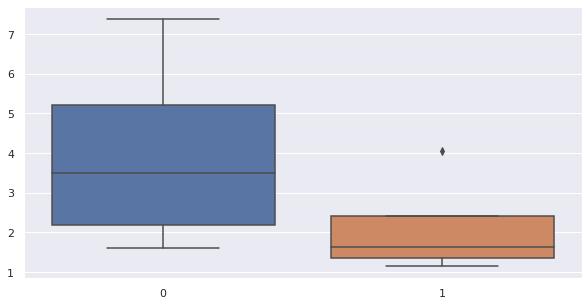

In [ ]:
#O valor obtido pelo pvalue acima do valor crítico indica evidência forte a favor da hipótese
plt.figure(figsize=(10,5))

municipios12 = aux[aux['nivel_de_gastos'] <= 2]
municipios35 = aux[aux['nivel_de_gastos'] >= 3]

sns.boxplot(data=[municipios12[['taxa_mortalidade']], municipios35[['taxa_mortalidade']]])

### Comparando gastos em Caruaru e em Paulista
Ambos possuem uma população estimada próxima porém Paulista apresenta números muito piores que Caruaru

In [436]:
#Investimento por mês em Caruaru
InvestPerMonthCaruaru = pd.DataFrame({'dates' : dates})
InvestPerMonthCaruaru['month_name'] = InvestPerMonthCaruaru['dates'].dt.strftime('%b')
InvestPerMonthCaruaru['gastos'] = invest_covidPe[invest_covidPe['municipio'] == "CARUARU"].groupby(by=['data_hora']).sum().values
InvestPerMonthCaruaru['gastos_log10'] = InvestPerMonthCaruaru['gastos'].apply(np.log10)

#Investimento por mês em Paulista

InvestPerMonthPaulista = pd.DataFrame({'dates' : dates})
InvestPerMonthPaulista['month_name'] = InvestPerMonthPaulista['dates'].dt.strftime('%b')
InvestPerMonthPaulista['gastos'] = invest_covidPe[invest_covidPe['municipio'] == "PAULISTA"].groupby(by=['data_hora']).sum().values
InvestPerMonthPaulista['gastos_log10'] = InvestPerMonthPaulista['gastos'].apply(np.log10)


[Text(0, 0.5, 'Gastos Log10'), Text(0.5, 0, 'Mês'), Text(0.5, 1.0, 'Paulista')]

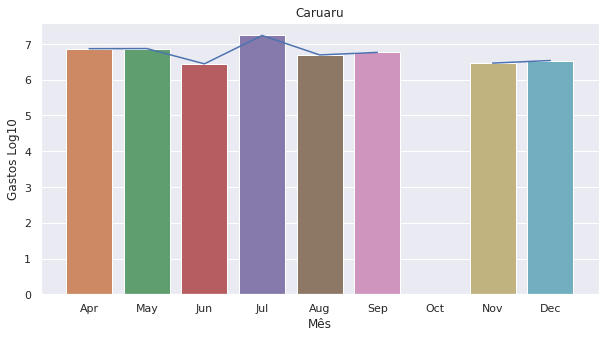

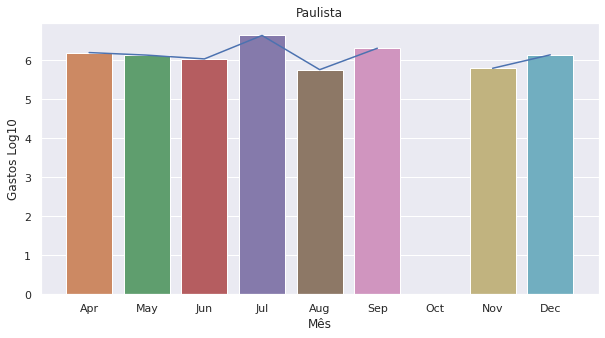

In [443]:
plt.figure(figsize=(10,5))
sns.barplot(x='month_name', y='gastos_log10', data=InvestPerMonthCaruaru).set(title='Caruaru', xlabel='Mês', ylabel='Gastos Log10')
sns.lineplot(x='month_name', y='gastos_log10', data=InvestPerMonthCaruaru)

plt.figure(figsize=(10,5))
sns.barplot(x='month_name', y='gastos_log10', data=InvestPerMonthPaulista)
sns.lineplot(x='month_name', y='gastos_log10', data=InvestPerMonthPaulista).set(title='Paulista', xlabel='Mês', ylabel='Gastos Log10')

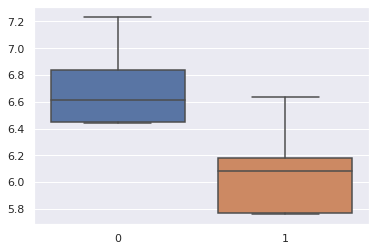

In [428]:
sns.boxplot(data=[InvestPerMonthCaruaru[['gastos_log10']], InvestPerMonthPaulista[['gastos_log10']]])

Os gastos com Paulista são muito menores que os gastos em Caruaru apesar de terem populações parecidas. Como já vimos anteriormente, os investimentos fizeram total diferença, pois apesar de terem uma quantidade de haitantes parecida, os níveis de taxa de mortalidade na cidade de Paulista são bem maiores

## Previsão de gastos para o primeiro trimestre de 2021
  * Utilizaremos previsões em Séries Temporais
  * Recursos:
    - Pandas
    - Facebook Prophet

O `numpy` possui um tipo específico para lidar com datetime, que é o `np.datetime64`, utilizado para indexar dataframes de séries temporais. Com isso, podemos fazer operações vetorizadas.

In [ ]:
import numpy as np
date_index = np.datetime64("2018-07-02") + np.arange(12)
date_index

array(['2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05',
       '2018-07-06', '2018-07-07', '2018-07-08', '2018-07-09',
       '2018-07-10', '2018-07-11', '2018-07-12', '2018-07-13'],
      dtype='datetime64[D]')

### `DatetimeIndex`

Podemos manipular diretamente no `pandas` para criar *índices* temporais.

In [ ]:
import pandas as pd
date = pd.to_datetime("2018-07-02")
date += pd.to_timedelta(np.arange(60), 'D')
date

DatetimeIndex(['2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05',
               '2018-07-06', '2018-07-07', '2018-07-08', '2018-07-09',
               '2018-07-10', '2018-07-11', '2018-07-12', '2018-07-13',
               '2018-07-14', '2018-07-15', '2018-07-16', '2018-07-17',
               '2018-07-18', '2018-07-19', '2018-07-20', '2018-07-21',
               '2018-07-22', '2018-07-23', '2018-07-24', '2018-07-25',
               '2018-07-26', '2018-07-27', '2018-07-28', '2018-07-29',
               '2018-07-30', '2018-07-31', '2018-08-01', '2018-08-02',
               '2018-08-03', '2018-08-04', '2018-08-05', '2018-08-06',
               '2018-08-07', '2018-08-08', '2018-08-09', '2018-08-10',
               '2018-08-11', '2018-08-12', '2018-08-13', '2018-08-14',
               '2018-08-15', '2018-08-16', '2018-08-17', '2018-08-18',
               '2018-08-19', '2018-08-20', '2018-08-21', '2018-08-22',
               '2018-08-23', '2018-08-24', '2018-08-25', '2018-08-26',
      

In [ ]:
df = pd.DataFrame(np.arange(len(date)), index=date)
df.tail()

,0
2018-08-26,55
2018-08-27,56
2018-08-28,57
2018-08-29,58
2018-08-30,59


Podemos indexar diretamente pelo tempo:

In [ ]:
df["2018-07-05" : "2018-07-08"]

,0
2018-07-05,3
2018-07-06,4
2018-07-07,5
2018-07-08,6


In [ ]:
df["2018-07"].tail()

,0
2018-07-27,25
2018-07-28,26
2018-07-29,27
2018-07-30,28
2018-07-31,29


### `pd.date_range`

Regularmente é usada essa função para criar "fatias" de tempo.

In [ ]:
pd.date_range('2018-07-02', '2018-07-03', freq='D')

DatetimeIndex(['2018-07-02', '2018-07-03'], dtype='datetime64[ns]', freq='D')

In [ ]:
pd.date_range('2018-07-02', periods=20, freq='s')

DatetimeIndex(['2018-07-02 00:00:00', '2018-07-02 00:00:01',
               '2018-07-02 00:00:02', '2018-07-02 00:00:03',
               '2018-07-02 00:00:04', '2018-07-02 00:00:05',
               '2018-07-02 00:00:06', '2018-07-02 00:00:07',
               '2018-07-02 00:00:08', '2018-07-02 00:00:09',
               '2018-07-02 00:00:10', '2018-07-02 00:00:11',
               '2018-07-02 00:00:12', '2018-07-02 00:00:13',
               '2018-07-02 00:00:14', '2018-07-02 00:00:15',
               '2018-07-02 00:00:16', '2018-07-02 00:00:17',
               '2018-07-02 00:00:18', '2018-07-02 00:00:19'],
              dtype='datetime64[ns]', freq='S')

### Métodos

In [ ]:
!pip install --quiet pandas-datareader

In [ ]:
!pip install --quiet yfinance

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() 
start_date = datetime(2016, 1, 1)
end_date = datetime(2020, 9, 25)
df = pdr.get_data_yahoo("^BVSP", start=start_date, end=end_date)
df.index = pd.to_datetime(df.index) # indice nao vem como datetime
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-18,100098.0,100102.0,98045.0,98290.0,98290.0,11370300
2020-09-21,98283.0,98283.0,95820.0,96991.0,96991.0,9738000
2020-09-22,96995.0,97684.0,96390.0,97294.0,97294.0,7281300
2020-09-23,97294.0,97389.0,95728.0,95735.0,95735.0,8830700
2020-09-24,95735.0,97955.0,95653.0,97012.0,97012.0,9331000


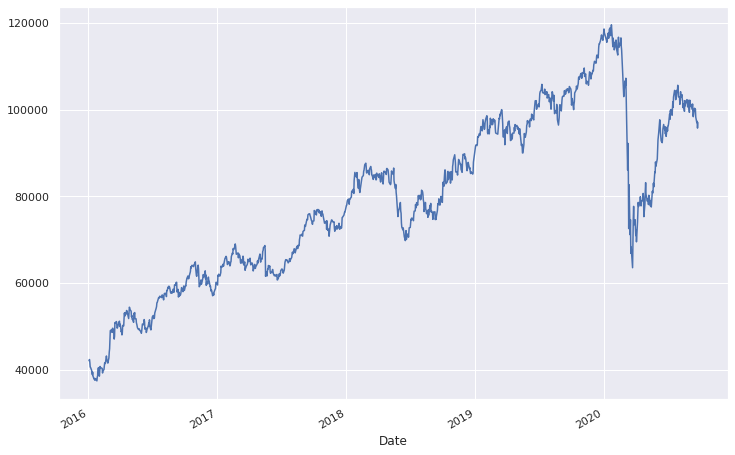

In [ ]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(12, 8))
data = df.Close
data.plot()

Uma necessidade comum com séries temporais é de obter uma amostra do dado em uma frequência menor do que o dado original, seja agrupando ou selecionando.

* `asfreq`: *data selection*
* `resample`: *data aggregation*

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

No exemplo abaixo, `resample` mostra a média do ano anterior, enquanto `asfreq` reporta o valor final ao fim do ano.

In [ ]:
data.resample('182D').mean()

Date
2016-01-04     47370.064516
2016-07-04     59099.648000
2017-01-02     64400.105691
2017-07-03     71697.379032
2018-01-01     81694.131148
2018-07-02     81568.434426
2018-12-31     95947.842975
2019-07-01    105147.488000
2019-12-30     94105.520661
2020-06-29    100731.253968
Freq: 182D, Name: Close, dtype: float64

In [ ]:
data.asfreq('182D')

Date
2016-01-04    201.020004
2016-07-04           NaN
2017-01-02           NaN
2017-07-03    242.210007
2018-01-01           NaN
2018-07-02    271.859985
2018-12-31    249.919998
2019-07-01    295.660004
2019-12-30    321.079987
2020-06-29    304.459991
Freq: 182D, Name: Close, dtype: float64

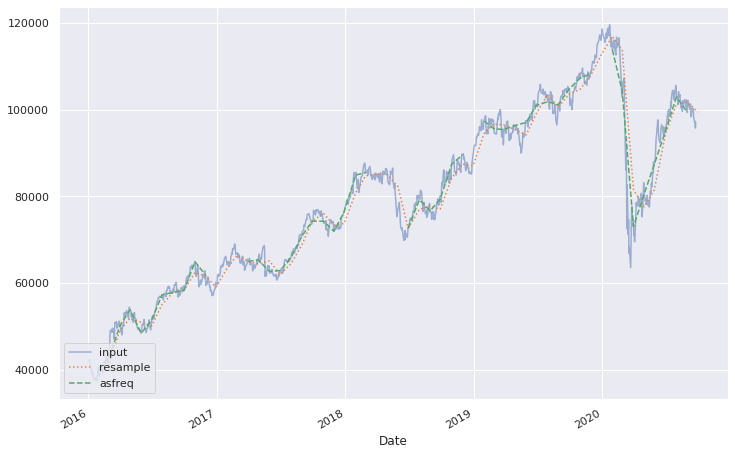

In [ ]:
plt.figure(figsize=(12, 8))
data["2016":].plot(alpha=0.5, style='-')
data.resample('BM').mean().plot(style=':')
data.asfreq('BM').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'], loc='lower left');

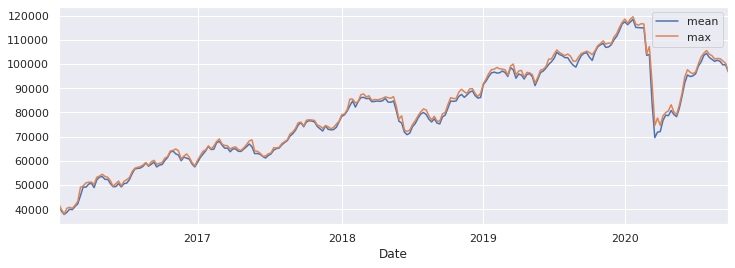

In [ ]:
plt.figure(figsize=(12, 4))
data.resample("W").mean().plot(label='mean')
data.resample("W").max().plot(label='max')
plt.legend()

### Janela deslizante

Outra aplicação comum em processamento de séries temporais são operações de janelas deslizantes. 

Rolling [window=182,center=False,axis=0]

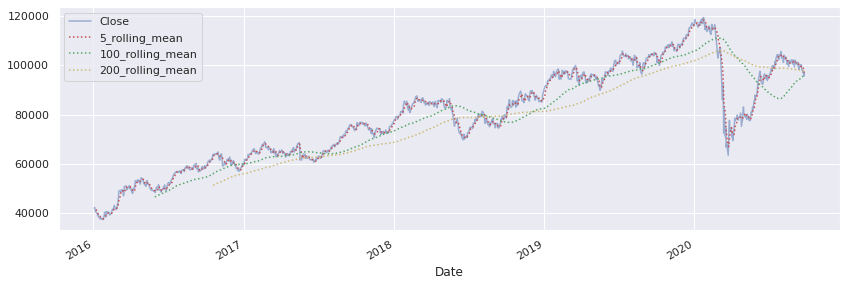

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(211)
data.plot(alpha=.5)
(data.rolling(5)
 .mean()
 .plot(label="5_rolling_mean", style='r:', alpha=1)
)
(data.rolling(100)
 .mean()
 .plot(label="100_rolling_mean", style='g:', alpha=1)
)
(data.rolling(200)
 .mean()
 .plot(label="200_rolling_mean", style='y:', alpha=1)
)
plt.legend()

In [ ]:
data.head()

Date
2016-01-04    42141.0
2016-01-05    42419.0
2016-01-06    41773.0
2016-01-07    40695.0
2016-01-08    40612.0
Name: Close, dtype: float64

In [ ]:
a = data.resample("m") # reamostragem de acordo com o mes


pandas.core.resample.DatetimeIndexResampler

In [ ]:
data.resample("m") # reamostragem de acordo com o mes
data.rolling(182).mean() # funcoes de janela deslizente 
data.index.dayofweek # transforma todo indice em dayofweek
data.groupby # funcao de agrupamento

<bound method Series.groupby of Date
2016-01-04    201.020004
2016-01-05    201.360001
2016-01-06    198.820007
2016-01-07    194.050003
2016-01-08    191.919998
                 ...    
2020-09-18    330.649994
2020-09-21    326.970001
2020-09-22    330.299988
2020-09-23    322.640015
2020-09-24    323.500000
Name: Close, Length: 1191, dtype: float64>

In [ ]:
data.resample("m").sum()

Date
2016-01-31     748413.0
2016-02-29     779481.0
2016-03-31    1081831.0
2016-04-30    1037043.0
2016-05-31    1071339.0
2016-06-30    1103548.0
2016-07-31    1155462.0
2016-08-31    1333725.0
2016-09-30    1226915.0
2016-10-31    1249548.0
2016-11-30    1232388.0
2016-12-31    1241651.0
2017-01-31    1334206.0
2017-02-28    1196002.0
2017-03-31    1495648.0
2017-04-30    1160440.0
2017-05-31    1432575.0
2017-06-30    1302342.0
2017-07-31    1354590.0
2017-08-31    1582513.0
2017-09-30    1486136.0
2017-10-31    1598433.0
2017-11-30    1393804.0
2017-12-31    1474999.0
2018-01-31    1697375.0
2018-02-28    1440003.0
2018-03-31    1789139.0
2018-04-30    1785676.0
2018-05-31    1728195.0
2018-06-30    1526296.0
2018-07-31    1616865.0
2018-08-31    1789410.0
2018-09-30    1464191.0
2018-10-31    1852337.0
2018-11-30    1661368.0
2018-12-31    1567178.0
2019-01-31    1984417.0
2019-02-28    1934376.0
2019-03-31    1735573.0
2019-04-30    2002761.0
2019-05-31    2071697.0
2019-06-30 

In [ ]:
resampled.rolling(3).mean()

Date
2016-01-31             NaN
2016-02-29             NaN
2016-03-31    8.699083e+05
2016-04-30    9.661183e+05
2016-05-31    1.063404e+06
2016-06-30    1.070643e+06
2016-07-31    1.110116e+06
2016-08-31    1.197578e+06
2016-09-30    1.238701e+06
2016-10-31    1.270063e+06
2016-11-30    1.236284e+06
2016-12-31    1.241196e+06
2017-01-31    1.269415e+06
2017-02-28    1.257286e+06
2017-03-31    1.341952e+06
2017-04-30    1.284030e+06
2017-05-31    1.362888e+06
2017-06-30    1.298452e+06
2017-07-31    1.363169e+06
2017-08-31    1.413148e+06
2017-09-30    1.474413e+06
2017-10-31    1.555694e+06
2017-11-30    1.492791e+06
2017-12-31    1.489079e+06
2018-01-31    1.522059e+06
2018-02-28    1.537459e+06
2018-03-31    1.642172e+06
2018-04-30    1.671606e+06
2018-05-31    1.767670e+06
2018-06-30    1.680056e+06
2018-07-31    1.623785e+06
2018-08-31    1.644190e+06
2018-09-30    1.623489e+06
2018-10-31    1.701979e+06
2018-11-30    1.659299e+06
2018-12-31    1.693628e+06
2019-01-31    1.737654e

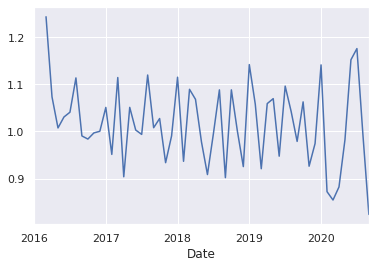

In [ ]:
resampled = data.resample("m").sum()
resp = (resampled / resampled.rolling(3).mean())
resp.plot()

### Exercícios

1. Plote um gráfico que mostra a variação percentual mensal entre o volume de *trades* ocorridos nesse mês em relação à média dos últimos 3 meses.

2. Qual o dia da semana que há maior volume de *trades*? Plot um gráfico que mostra a mediana de trades por dia da semana (pode ser um gráfico de barras).
 
    *Hint #1*: manipule o índice temporal.
    
    *Hint #2*: use a operação de agrupamento `groupby`.

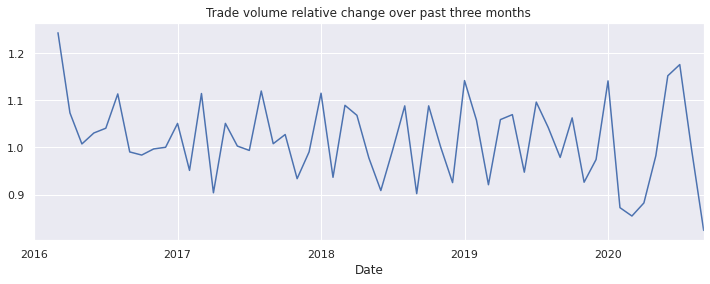

In [ ]:
plt.figure(figsize=(12, 4))
monthly = data.resample("m").sum()
diff = (monthly / monthly.rolling(3).mean())
diff.plot(title="Trade volume relative change over past three months")

In [ ]:
df.Volume.groupby((df.Volume.index.dayofweek)).median()

Date
0    3504900
1    3921300
2    4233500
3    4050800
4    4079900
Name: Volume, dtype: int64

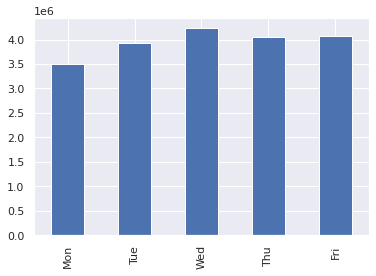

In [ ]:
median_by_day = df.Volume.groupby(df.Volume.index.dayofweek).median()
median_by_day.index = ["Mon", "Tue", "Wed", "Thu", "Fri"]
median_by_day.plot(kind="bar")

### Bonus: Prophet

> "Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."

Utilizaremos para ver quão bom o `prophet` é em prever um indicador da bolsa de valores (e exatamente porque você não deveria fazer isso).

In [ ]:
!pip install --quiet fbprophet

In [ ]:
from fbprophet import Prophet

prophet_df = df[["Close"]].reset_index()
prophet_df.columns = ["ds", "y"]
prophet_df.tail()

,ds,y
1165,2020-09-18,98290.0
1166,2020-09-21,96991.0
1167,2020-09-22,97294.0
1168,2020-09-23,95735.0
1169,2020-09-24,97012.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


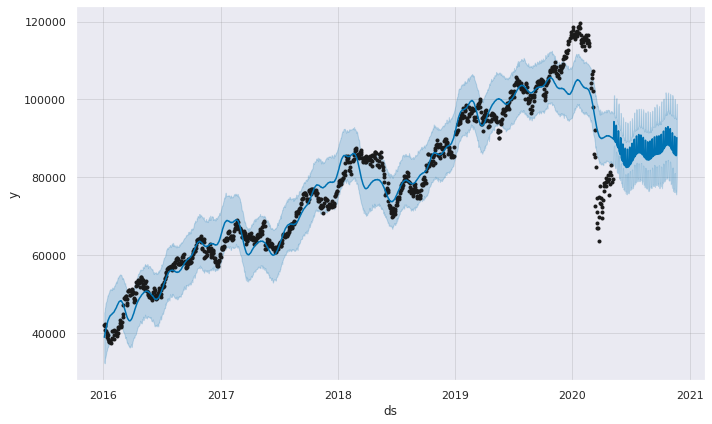

In [ ]:
m = Prophet()
m.fit(prophet_df[:-100])
pred = m.predict(m.make_future_dataframe(periods=200))
m.plot(pred); # weird bug causes to plot twice, put ; in the end

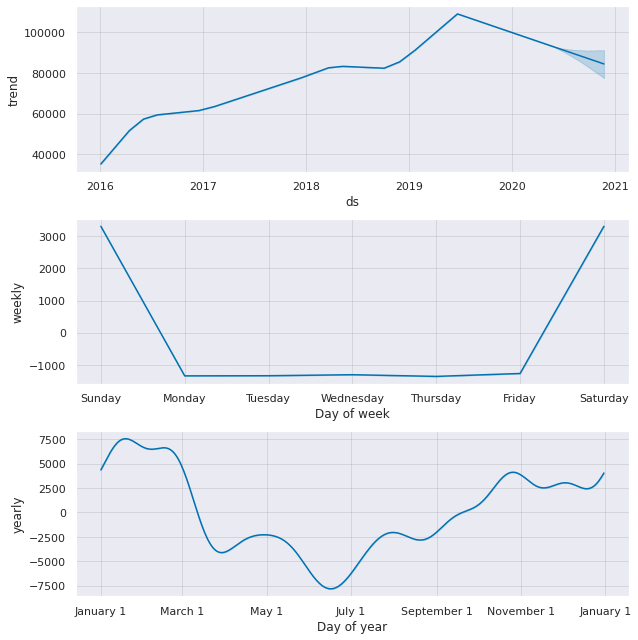

In [ ]:
m.plot_components(pred);

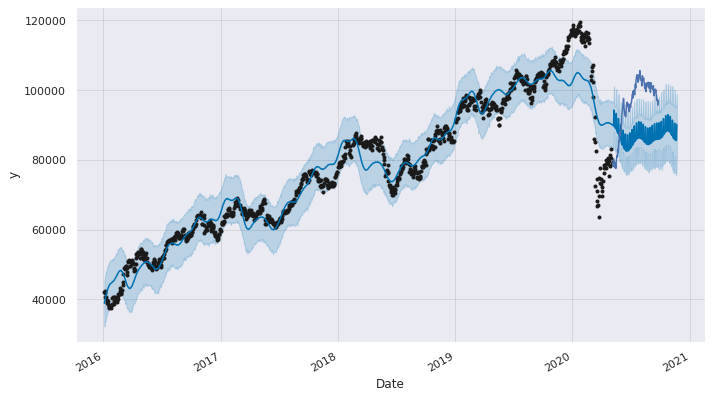

In [ ]:
m.plot(pred); # weird bug causes to plot twice, put ; in the end
df.Close[-100:].plot()

### Referências

#### Tutoriais:

* Vários notebooks com tutoriais: https://github.com/jakevdp/PythonDataScienceHandbook/ (maior parte da aula veio daqui)
* prophet docs: https://facebook.github.io/prophet/docs/quick_start.html#python-api
* statsmodels docs: https://www.statsmodels.org/stable/examples/index.html#stats


#### Indústria:

* **Uber**
    * [Forecasting at Uber: An Introduction](https://eng.uber.com/forecasting-introduction/)
    * [Engineering Extreme Event Forecasting at Uber with Recurrent Neural Networks](https://eng.uber.com/neural-networks/) (Avançado)
    
* **Lyft**
    * [How to deal with the seasonality of a market?](https://eng.lyft.com/how-to-deal-with-the-seasonality-of-a-market-584cc94d6b75)
    
* **Airbnb**
    * [Learning Market Dynamics for Optimal Pricing](https://medium.com/airbnb-engineering/learning-market-dynamics-for-optimal-pricing-97cffbcc53e3)
    * [Anomaly Detection for Aibnb's Payment Platform](https://medium.com/airbnb-engineering/anomaly-detection-for-airbnb-s-payment-platform-e3b0ec513199)